In [1]:
import torch
import torch.nn as nn
import gym
from itertools import count
import numpy as np
import random
import torch.nn.functional as F

envs = ['CartPole-v1','Acrobot-v1','MountainCar-v0','Pendulum-v0','BipedalWalker-v2']
env = gym.make(envs[0]).unwrapped

discrete_actions = True
#TODO
#parralel fitness measuring
from helper import *
%matplotlib inline
import matplotlib.pyplot as plt
#seed = 69
#random.seed(seed)
#np.random.seed(seed)
#torch.cuda.manual_seed_all(seed)
#torch.manual_seed(seed)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class Creature(nn.Module):
    def __init__(self):
        super(Creature, self).__init__()
    
        self.layer1 = nn.Linear(env.observation_space.shape[0], 6)
        self.layer2 = nn.Linear(6, 6)
        
        if discrete_actions:
            self.layer3 = nn.Linear(6, env.action_space.n)
        else:
            self.layer3 = nn.Linear(6, env.action_space.shape[0])
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

class Generator(nn.Module):
    def __init__(self,input_num,output_num):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose1d(input_num, 128, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(True))
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose1d(128, 64, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(True))
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose1d(64, 32, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(32),
            nn.ReLU(True))
        
        self.layer4 = nn.Sequential(
            nn.ConvTranspose1d(32, 16, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(16),
            nn.ReLU(True))
        
        
        self.layer5 = nn.Linear(16*13, output_num)
        
    def forward(self, out):
        
        out = out.unsqueeze(-1)
        #print(out.shape)
        out = self.layer1(out)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = self.layer3(out)
        #print(out.shape)
        out = self.layer4(out)
        #print(out.shape)
        out = out.view(out.size(0),out.size(1)*out.size(2))
        out = self.layer5(out)
        
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 16, 5, stride=1, padding=0),  
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(16, 8, 5, stride=1, padding=0),  
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool1d(2, stride=1))
        
        self.layer2 = nn.Sequential(
            nn.Conv1d(8, 32, 5, stride=1,padding=0),  
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 16, 5, stride=1,padding=0),  
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool1d(2, stride=1))
        
        self.layer3 = nn.Sequential(
            nn.Conv1d(16, 32, 5, stride=1,padding=0),  
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 16, 5, stride=1,padding=0),  
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool1d(2, stride=1))
        
        self.layer4 = nn.Linear(16*59, 128)
        self.layer5 = nn.Sequential(       
            nn.Linear(128, 2),
            nn.Sigmoid())
    def forward(self, out):
        
        out = out.unsqueeze(1)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),out.size(1)*out.size(2))
        
        out = self.layer4(out)
        out = self.layer5(out)
        return out
gen = Generator((86*2)+1,86).to(device)
gen(torch.zeros([10,(86*2)+1]).to(device)).shape

#dis = Discriminator().to(device)
#dis(torch.zeros([10,86]).to(device)).shape    

torch.Size([10, 86])

In [3]:
def mate(m,d,use_gen,dominance = 0.5,mutation_rate=0.2,mutation_scale=0.07):
    dom = torch.from_numpy(np.array(dominance)).to(device).unsqueeze(-1).type("torch.cuda.FloatTensor")
    child = Creature()
    mom = (m)
    dad = (d)
    
    mom = mutate(mom,mutation_rate,mutation_scale)
    dad = mutate(dad,mutation_rate,mutation_scale)
    mom = get_params(mom)
    dad = get_params(dad)
    generated = use_gen(torch.cat([dad,mom,dom]).unsqueeze(0)).squeeze(0)
    child = set_params(child,generated)
    child = mutate(child,mutation_rate,mutation_scale)
    return child

def mutate(creature,mutation_rate=0.2,scale = 0.07):
    if mutation_rate != 0:
        new = Creature().to(device)
        new.load_state_dict(creature.state_dict()) 
        for p in new.parameters():

            mutation = np.random.normal(scale = scale,size = p.data.shape)
            mutation *= np.random.choice([1, 0], p.data.shape,p=[mutation_rate,1-mutation_rate])
            mutation = torch.from_numpy(mutation).type('torch.FloatTensor').to(device)
            p.data += mutation
        return new
    else:
        return creature

def evolve(population,out_size,new_gen,old_gen,pf_fitness,mutation_rate,mutation_scale):
    p_fitness_positive = p_fitness - np.min(p_fitness) + 1
    pick_probabilities = get_pick_probabilities(pf_fitness)
    
    
    choice = np.random.choice(pick_probabilities.size,out_size, p = pick_probabilities)
    new_population = []
    
    for p in range(out_size-1):
        first_choice = population[choice[p]]
        second_choice = population[choice[p+1]]
        if random.randint(0, 10) >= 2:
            use_gen = new_gen
        else: 
            use_gen = old_gen
        #more succesful(healthier?) creature has greater genetic dominance
        f1 = p_fitness_positive[choice[p]]
        f2 = p_fitness_positive[choice[p+1]]
        if  f1>=f2 :
            dominance = (f2/f1) * 0.5
            np.clip(dominance,0.3,0.7)
            child = mate(second_choice,first_choice,use_gen,dominance,mutation_rate,mutation_scale).to(device)
        else:
            dominance = (f1/f2) * 0.5
            np.clip(dominance,0.3,0.7)
            child = mate(first_choice,second_choice,use_gen,dominance,mutation_rate,mutation_scale).to(device)
            
        new_population.append(child)
        
    child = mate(population[0],population[len(population)-1],use_gen ,mutation_rate,mutation_scale).to(device) 
    new_population.append(child)
    
    return new_population



In [4]:



def train_gan(population,p_fitness,min_fit,fit_bank,min_gen = 0.6,min_dis = 0.5,batch_size = 20,n_epochs = 100):
    ranking = (p_fitness>=min_fit)*1 #* (p_fitness/np.max(p_fitness)) 
    if fit_bank.size > 0:
        ranking = np.append(ranking,np.ones([fit_bank.size]))
        population = np.append(population,fit_bank)
        
    #yeet, behavior_samples = measure_population_fitness(population,env,device,discrete_actions,
    #                                                         max_steps = 500)
    #print(yeet)
    print(min_fit)
    print(ranking)
    
    ranking = torch.from_numpy(ranking).to(device).type("torch.cuda.FloatTensor")
    gen_error = 1000
    dis_error_fake = 1000
    dis_error_real = 1000
    e = 0
    
    gen_loss_all = []
    dis_loss_all = []
    rec_loss_all = []
    while True:
        e += 1
        if e >= n_epochs:# and dis_error_fake+dis_error_real < min_dis and gen_error < min_gen:
            break
        #shuffle arrays in unison
        #ind = np.arange(len(population))
        #np.random.shuffle(ind)
        #population = population[ind]
        #ranking = ranking[ind]
        
        for i in range(len(population)//batch_size):

            gen_optimizer.zero_grad()
            dis_optimizer.zero_grad()
            
            real_batch = []
            for b in range(batch_size):
                real_batch.append(get_params(population[(i*batch_size)+b]).unsqueeze(0))
            real_batch = torch.cat(real_batch, dim=0).to(device)
            
            #train discriminator on population
            if dis_error_real > 0.05:
                
                dis_out = dis(real_batch).squeeze(-1)
                
                stack = [ranking[i*batch_size:(i*batch_size)+batch_size],torch.ones(batch_size).to(device)]
                stack = torch.stack(stack)
                
                #dis_error_real = nn.BCELoss()(dis_out,
                    #ranking[i*batch_size:(i*batch_size)+batch_size])#torch.ones(batch_size).to(device))
                dis_error_real = nn.BCELoss()(dis_out,stack.transpose(0,1))
                
                dis_error_real.backward()
                
        
            #train discriminator on generator output
            mom = []
            dad = []
            child = []
            dominance = torch.from_numpy((np.random.rand(batch_size)*0.5) + 0.25).to(device).unsqueeze(-1)
            dominance = dominance.type("torch.cuda.FloatTensor")
            for b in range(batch_size):
                m = get_params(random.choice(population))
                d = get_params(random.choice(population))
                c_data = torch.cat([m,d,dominance[b]]).unsqueeze(0)
                #c_data = torch.cat([c_data,dominance[b]]).unsqueeze(0)
                c = gen(c_data).squeeze(0)

                mom.append(m)
                dad.append(d)
                child.append(c)
            
            mom = torch.stack(mom).to(device)
            dad = torch.stack(dad).to(device)
            child = torch.stack(child).to(device)
            dis_out = dis(child).squeeze(-1)
            if dis_error_fake > 0.7 or gen_error < 0.5:
                dis_error_fake = nn.BCELoss()(dis_out,torch.zeros(dis_out.shape).to(device)) 
                dis_error_fake.backward(retain_graph=True)
                
            dis_optimizer.step()        
            
            #train generator
            #if gen_error > 0.6:
            #mom_loss = torch.pow(torch.sub(child,mom),2) #* (dominance)
            #dad_loss = torch.pow(torch.sub(child,dad),2)# * (1-dominance)

            #mom_loss = torch.mean(mom_loss)
            #dad_loss = torch.mean(dad_loss)
            
            dad_loss = torch.nn.MSELoss()(dad,child)
            mom_loss = torch.nn.MSELoss()(mom,child)
            #if mom_loss > dad_loss:
            #    child_error = torch.div(mom_loss,dad_loss)-1
            #else:

            child_error = (mom_loss + dad_loss) * 0.01

            gen_error = nn.BCELoss()(dis_out,torch.ones(dis_out.shape).to(device))
            total_gen_error = gen_error  + child_error
            total_gen_error.backward()
            gen_optimizer.step()
            
        gen_loss_all.append(gen_error)
        dis_loss_all.append(dis_error_fake+dis_error_real)
        rec_loss_all.append(child_error)    
            
        #if e %  5 == 0:    
        #print("Discriminator loss real : {}".format(dis_error_real))
        #print("Discriminator loss generated : {}".format(dis_error_fake))
        #print("Generator loss : {}".format(gen_error))
        #print("Child error : {}".format(child_error*0.1))
        #print("")
    return gen_loss_all, dis_loss_all, rec_loss_all

starting training
[ 9. 11.]
(array([], dtype=int64),)
11.0
[0 1]


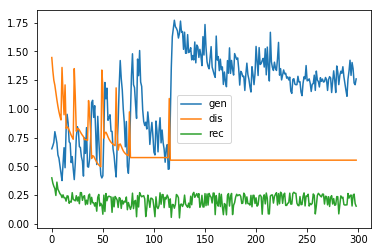

Generation 1  fitness : 11.0
#################################
[ 8.  9. 23.  9.]
(array([], dtype=int64),)
14.333333333333334
[0 0 1 0]


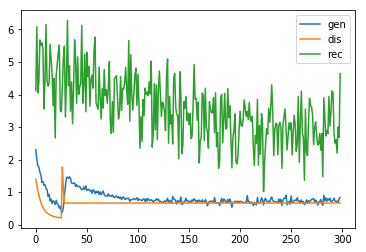

Generation 2  fitness : 23.0
#################################
[102. 125. 695.  10.]
(array([], dtype=int64),)
236.25
[0 0 1 0]


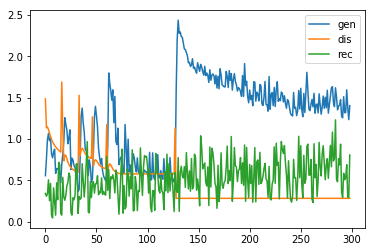

Generation 3  fitness : 695.0
#################################
[ 61. 100.  78.  96.  41.  17.]
(array([2]),)
223.6
[0. 0. 0. 0. 0. 0. 1.]


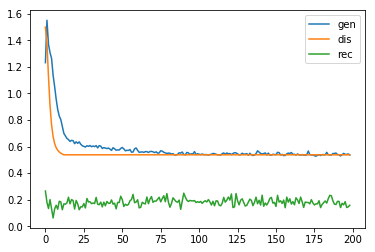

Generation 4  fitness : 100.0
#################################
[1000.  691.   77. 1000. 1000. 1000.]
(array([], dtype=int64),)
798.5
[1 0 0 1 1 1]


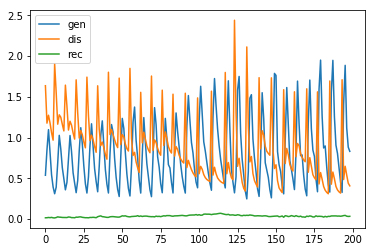

Generation 5  fitness : 1000.0
#################################
[302. 262. 170. 171. 177.  24. 166.  18.]
(array([0, 3, 4, 5]),)
750.7142857142857
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]


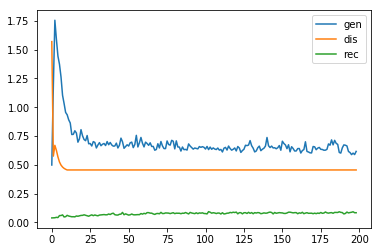

Generation 6  fitness : 302.0
#################################
[ 13.  10.  23.  13.  24.  15. 251.  10.]
(array([0, 1]),)
190.375
[0. 0. 0. 0. 0. 0. 1. 0. 1. 1.]


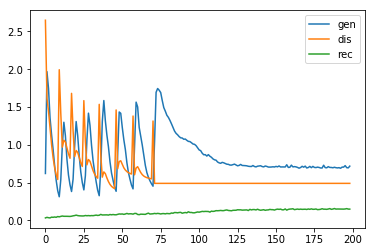

Generation 7  fitness : 251.0
#################################
[ 103. 1000.  436.   97.  279. 1000.   96.   87.  196.  104.]
(array([], dtype=int64),)
385.1111111111111
[0 1 1 0 0 1 0 0 0 0]


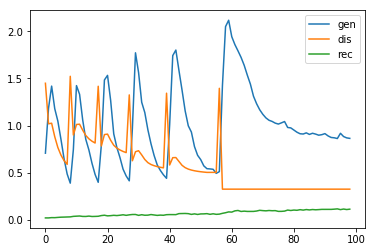

Generation 8  fitness : 1000.0
#################################
[418. 246. 324. 179.  12.  35. 114.  29. 527. 175.]
(array([1, 5]),)
460.5
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.]


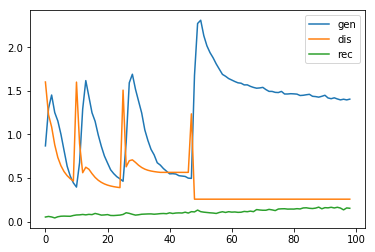

Generation 9  fitness : 527.0
#################################
[241. 327. 117. 265. 122. 199. 333. 221. 206. 125. 104. 507.]
(array([0, 8]),)
328.6363636363636
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1.]


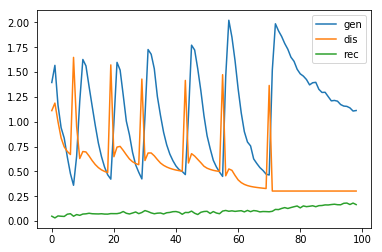

Generation 10  fitness : 507.0
#################################
[1000.   85.   49.  109.  145.  312.  168.  129.  191.  211.  160.  133.]
(array([11]),)
334.4166666666667
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


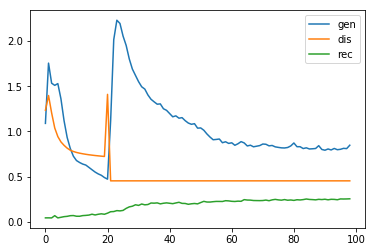

Generation 11  fitness : 1000.0
#################################
[ 79. 203.  81.  55.  88. 173. 131.  44.  49. 150.  45. 122.  58. 133.]
(array([0, 5]),)
239.23076923076923
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


In [ ]:
#randomly inititialise starting population
population_size = 2
max_population = 26
batch_size = population_size
out_size = population_size
population = []

for p in range(population_size):
    population.append(Creature().to(device))
    
old_population = population 

gen = Generator((86*2)+1,86).to(device)
old_gen = gen
dis = Discriminator().to(device)

lr = 0.0002
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=lr,betas=(0.5,0.999))
dis_optimizer = torch.optim.Adam(dis.parameters(), lr=lr,betas=(0.5,0.999))

print("starting training")
n_generations = 100


fit_bank = np.array([])
for i in range(n_generations):
    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=lr,betas=(0.5,0.999))
    dis_optimizer = torch.optim.Adam(dis.parameters(), lr=lr,betas=(0.5,0.999))
    p_fitness, behavior_samples = measure_population_fitness(population,env,device,discrete_actions,
                                                             max_steps = 1000)
    print(p_fitness)
    
    
    if i == 0:
        old_fitness = p_fitness
    cat = np.concatenate([p_fitness,old_fitness])
    min_fit = np.mean(np.sort(cat)[int(cat.size)-int(cat.size/2):])
    if i < 3:
        min_gen = 1000
        n_epochs = 300#//(i+1)
    elif i < 7:
        min_gen = 0.5
        
        n_epochs = 200
    else:
        min_gen = 0.5
        
        n_epochs = 100
    print(np.where(old_fitness>min_fit))
    fit_bank = np.array(old_population)[np.where(old_fitness>min_fit)]
    gen_loss, dis_loss,rec_loss = train_gan(population,p_fitness,min_fit,fit_bank,min_dis = 0.8,min_gen=min_gen,
              batch_size = batch_size+fit_bank.size,n_epochs = n_epochs)
    
    plt.plot(gen_loss,label='gen')
    plt.plot(dis_loss,label='dis')
    plt.plot(rec_loss,label='rec')
    #plt.ylim(0, 15)
    plt.legend()
    plt.show()
    
    if i % 5 == 0:
        fitness = measure_fitness(population[np.argmax(p_fitness)],env,device,discrete_actions,render = True)
    
    mutation_rate = 0.15
    mutation_scale = 0.1
    if min_fit < 13:
        mutation_rate = 1
        mutation_scale = 0.9
        
    if out_size < max_population and i % 2 == 0:
        out_size+=2
        batch_size = out_size
    
    old_population = population
    old_fitness = p_fitness
    population = evolve(population,out_size,gen,old_gen,p_fitness,mutation_rate,mutation_scale)
    old_gen = gen
    print("Generation {}  fitness : {}".format(i+1,np.max(p_fitness)))
    print("#################################")
